<a href="https://colab.research.google.com/github/lucky096/llm_augmented_workflow/blob/main/Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langchain_core langgraph langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.32
    Uninstalling langchain-core-0.3.32:
      Successfully uninstalled langchain-core-0.3.32


In [ ]:
from langchain_groq import ChatGroq

GROQ_API_KEY = "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"
MODEL = "llama-3.3-70b-versatile"

llm = ChatGroq(temperature=0, model_name=MODEL, api_key=GROQ_API_KEY)

In [ ]:
#schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
  search_query: str = Field(None, description="Search query.")
  justification: str = Field(None, description="Why this query is relevant to user's request")

#augment the llm with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

#invoke the augmented llm
output = structured_llm.invoke("How does Creatinine score related to CKD?")
print(output)

#define a tool
def multiply(x: int, y: int) -> int:
  return x*y

#augment llm with tools
llm_with_tools = llm.bind_tools([multiply])

#invoke the llm with input that triggers the tool call
msg = llm_with_tools.invoke("What is 12 * 12?")

#get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'x': 12, 'y': 12},
  'id': 'call_8djd',
  'type': 'tool_call'}]

In [ ]:
output

SearchQuery(search_query='Creatinine score and CKD relationship', justification='To understand how Creatinine score is related to Chronic Kidney Disease (CKD)')

In [ ]:
#create tool calling agent
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool

@tool
def multiply(x: int, y: int) -> int:
  """Multiple x times y """
  return x*y

prompt = ChatPromptTemplate.from_messages([
    ("system", "You're a helpful assistant."),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}"),
])

tools = [multiply]
agent = create_tool_calling_agent(llm,tools,prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
agent_executor.invoke({"input": "What is 12*12?"})



> Entering new AgentExecutor chain...

Invoking: `multiply` with `{'x': 12, 'y': 12}`


144The answer to 12*12 is 144.

> Finished chain.


{'input': 'What is 12*12?', 'output': 'The answer to 12*12 is 144.'}

## Prompt Chaining: each LLM call processes the output of the previous one.

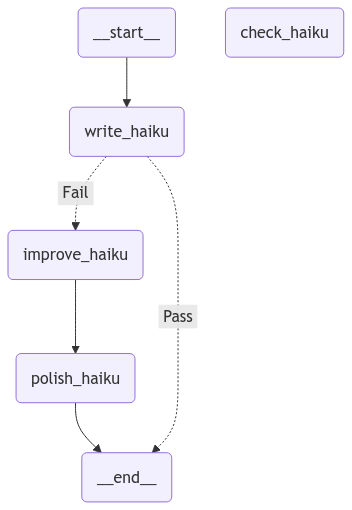

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

#Graph state
class State(TypedDict):
  topic: str
  haiku: str
  improved_haiku: str
  final_haiku: str

#nodes
def write_haiku(state: State):
  """1st LLM call to generate initial haiku"""

  msg = llm.invoke(f"Write a mini haiku about {state['topic']}")
  return {"haiku": msg.content}

def check_haiku(state: State):
  """Conditional function to check if the haiku is good"""

  # simple check - does the haiku contain "?" or "!"
  if "?" in state["haiku"] or "!" in state["haiku"]:
    return "Fail"
  return "Pass"

def improve_haiku(state: State):
  """2nd LLM call to improve the haiku"""

  msg = llm.invoke(f"Make this haiku interesting by adding similie: {state['haiku']}")
  return {"improved_haiku": msg.content}

def polish_haiku(state: State):
  """3rd LLM call for final refinement"""

  msg = llm.invoke(f"Add a sad ending to this haiku: {state['improved_haiku']}")
  return {"final_haiku": msg.content}

#build prompt chaining workflow
workflow = StateGraph(State)

#add nodes
workflow.add_node("write_haiku", write_haiku)
workflow.add_node("check_haiku", check_haiku)
workflow.add_node("improve_haiku", improve_haiku)
workflow.add_node("polish_haiku", polish_haiku)

#add edges to connect node
workflow.add_edge(START, "write_haiku")
workflow.add_conditional_edges("write_haiku", check_haiku, {"Fail": "improve_haiku", "Pass": END})
workflow.add_edge("improve_haiku", "polish_haiku")
workflow.add_edge("polish_haiku", END)

#compile
chain = workflow.compile()

#display workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [ ]:
#invoke the chain
state = chain.invoke({"topic": "cats"})
print("Initial haiku:")
print(state["haiku"])
print("\n------------\n")
if "improved_haiku" in state:
  print("Improved haiku:")
  print(state["improved_haiku"])
  print("\n----------\n")

  print("Final haiku:")
  print(state["final_haiku"])
else:
  print("Haiku failed conditional check - not a good haiku!")


Initial haiku:
Whiskers softly gleam
Moonlight dancing on their backs
Furry gentle souls

------------

Haiku failed conditional check - not a good haiku!


##Parallelization: LLMs work simultaneously on a task

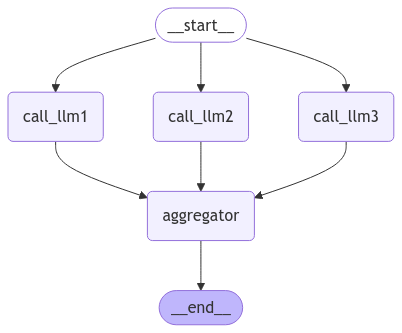

In [ ]:
#graph state
class State(TypedDict):
  topic: str
  haiku: str
  story: str
  poem: str
  combined_output: str

#nodes
def call_llm1(state: State):
  """1st llm call to write a haiku"""

  msg = llm.invoke(f"Write a haiku about {state['topic']}")
  return {"haiku": msg.content}

def call_llm2(state: State):
  """2nd llm call to write a story"""

  msg = llm.invoke(f"Write a story about {state['topic']}")
  return {"story": msg.content}

def call_llm3(state: State):
  """3rd llm call to write a poem"""

  msg = llm.invoke(f"Write a poem about {state['topic']}")
  return {"poem": msg.content}

def aggregator(state: State):
  """Combine the haiku, story and poem in to a single output"""

  combined = f"Here's a haiku, story and poem abount {state['topic']}!\n\n"
  combined += f"HAIKU:\n{state['haiku']}\n\n"
  combined += f"STORY:\n\n{state['story']}\n\n"
  combined += f"POEM: \n\n{state['poem']}"
  return {"combined_output": combined}

#build workflow
parallel_builder = StateGraph(State)

#add nodes
parallel_builder.add_node("call_llm1", call_llm1)
parallel_builder.add_node("call_llm2", call_llm2)
parallel_builder.add_node("call_llm3", call_llm3)
parallel_builder.add_node("aggregator", aggregator)

#add edges to connect nodes
parallel_builder.add_edge(START, "call_llm1")
parallel_builder.add_edge(START, "call_llm2")
parallel_builder.add_edge(START, "call_llm3")
parallel_builder.add_edge("call_llm1", "aggregator")
parallel_builder.add_edge("call_llm2", "aggregator")
parallel_builder.add_edge("call_llm3", "aggregator")
parallel_builder.add_edge("aggregator", END)

parallel_workflow = parallel_builder.compile()

#display workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [ ]:
#invoke the parallel workflow

state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a haiku, story and poem abount cats!

HAIKU:
Whiskers softly gleam
Moonlight dancing on their backs
Furry gentle souls

STORY:

In a small, cozy town surrounded by rolling hills and green pastures, there was a mystical place known as Whisker Woods. It was a feline paradise, where cats of all shapes and sizes roamed free, their tails twitching with excitement as they explored the winding paths and hidden clearings.

At the heart of Whisker Woods was a magnificent cat named Luna. She was a sleek and agile feline, with shimmering gray fur and piercing green eyes that seemed to see right through to the soul. Luna was the leader of the Whisker Woods cats, and she ruled with a gentle yet firm paw.

One sunny afternoon, a curious little kitten named Leo wandered into Whisker Woods. He was a ball of fluffy orange fur, with big round eyes and a mischievous grin. Leo had been separated from his family during a storm, and he had been searching for a new home ever since.

As he explored the

##Routing: Classifies an input and directs it to a followup task

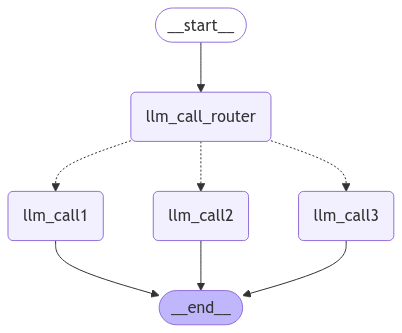

In [ ]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

#schema for structured output to use as routing logic
class Route(BaseModel):
  step: Literal["haiku", "story", "poem"] = Field(None, description="The next step in routing process")

#augment the llm with schema for structured output
router = llm.with_structured_output(Route)

#state
class State(TypedDict):
  input: str
  decision: str
  output: str

#nodes
def llm_call1(state: State):
  """write a haiku"""

  result = llm.invoke(state["input"])
  return {"output": result.content}

def llm_call2(state: State):
  """write a story"""

  result = llm.invoke(state["input"])
  return {"output": result.content}

def llm_call3(state: State):
  """write a poem"""

  result = llm.invoke(state["input"])
  return {"output": result.content}

def llm_call_router(state: State):
  """Route the input to the appropriate node"""

  #run the augmented llm with structured output to server as routing logic
  decision = router.invoke(
      [
          SystemMessage(
              content="Route the input to haiku, story, or poem based on the user's request"
          ),
          HumanMessage(content=state["input"])
      ]
  )
  return {"decision": decision.step}

#conditional edge function to route to the appropriate node
def route_decision(state: State):
  #return the node name you want to visit next
  if state["decision"] == "haiku":
    return "llm_call1"
  elif state["decision"] == "story":
    return "llm_call2"
  elif state["decision"] == "poem":
    return "llm_call3"

#build workflow
router_builder = StateGraph(State)

#add nodes
router_builder.add_node("llm_call1", llm_call1)
router_builder.add_node("llm_call2", llm_call2)
router_builder.add_node("llm_call3", llm_call3)
router_builder.add_node("llm_call_router", llm_call_router)

#add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "llm_call1": "llm_call1",
        "llm_call2": "llm_call2",
        "llm_call3": "llm_call3",
    },
)
router_builder.add_edge("llm_call1", END)
router_builder.add_edge("llm_call2", END)
router_builder.add_edge("llm_call3", END)

#compile
router_workflow = router_builder.compile()

#display workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [ ]:
#invoke the router workflow
state = router_workflow.invoke({"input": "Write me a haiku about cats"})
print(state["output"])

Whiskers softly gleam
Moonlight dancing on their backs
Furry gentle souls
